# Traffic Sign Classification with Keras

Keras exists to make coding deep neural networks simpler. To demonstrate just how easy it is, you’re going to use Keras to build a convolutional neural network in a few dozen lines of code.

You’ll be connecting the concepts from the previous lessons to the methods that Keras provides.

## Dataset

The network you'll build with Keras is similar to the example in Keras’s GitHub repository that builds out a [convolutional neural network for MNIST](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py). 

However, instead of using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, you're going to use the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) dataset that you've used previously.

You can download pickle files with sanitized traffic sign data here:

In [1]:
from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('train.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Train Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/train.p',
            'train.p',
            pbar.hook)

if not isfile('test.p'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Test Dataset') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/datasets/german_traffic_sign_benchmark/test.p',
            'test.p',
            pbar.hook)

print('Training and Test data downloaded.')

Training and Test data downloaded.


## Overview

Here are the steps you'll take to build the network:

1. Load the training data.
2. Preprocess the data.
3. Build a feedforward neural network to classify traffic signs.
4. Build a convolutional neural network to classify traffic signs.
5. Evaluate the final neural network on testing data.

Keep an eye on the network’s accuracy over time. Once the accuracy reaches the 98% range, you can be confident that you’ve built and trained an effective model.

In [2]:
import pickle
import numpy as np
import math

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

print('Modules loaded.')

Modules loaded.


## Load the Data

Start by importing the data from the pickle file.

In [3]:
with open('train.p', 'rb') as f:
    data = pickle.load(f)

X_train, y_train = data['features'], data['labels']

In [4]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert np.array_equal(X_train, data['features']), 'X_train not set to data[\'features\'].'
assert np.array_equal(y_train, data['labels']), 'y_train not set to data[\'labels\'].'
print('Tests passed.')

Tests passed.


## Preprocess the Data

1. Shuffle the data
2. Normalize the features using Min-Max scaling between -0.5 and 0.5
3. One-Hot Encode the labels

### Shuffle the data
Hint: You can use the [scikit-learn shuffle](http://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html) function to shuffle the data.

In [5]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [6]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert X_train.shape == data['features'].shape, 'X_train has changed shape. The shape shouldn\'t change when shuffling.'
assert y_train.shape == data['labels'].shape, 'y_train has changed shape. The shape shouldn\'t change when shuffling.'
assert not np.array_equal(X_train, data['features']), 'X_train not shuffled.'
assert not np.array_equal(y_train, data['labels']), 'y_train not shuffled.'
print('Tests passed.')

Tests passed.


### Normalize the features
Hint: You solved this in [TensorFlow lab](https://github.com/udacity/CarND-TensorFlow-Lab/blob/master/lab.ipynb) Problem 1.

Image data shape: (39209, 32, 32, 3) | Labels shape: (39209,)
Mean: 193.6035 | Std: 60.5934


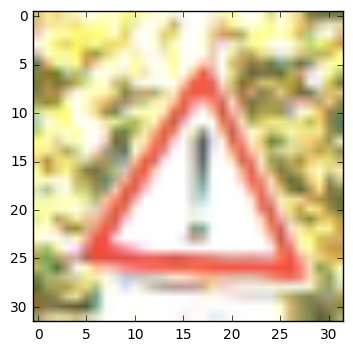

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print('Image data shape: %r | Labels shape: %r' % (X_train.shape, y_train.shape))
print('Mean: %0.4f | Std: %0.4f' % (np.mean(X_train[0,...]), np.std(X_train[0,...])))
plt.imshow(X_train[0,...])

In [8]:
def pre_process(images):
    import cv2
    transformed = []
    
    for image in images:
        im = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        im[0,...] = cv2.equalizeHist(im[0,...])
        im = cv2.cvtColor(im, cv2.COLOR_YUV2RGB)
        im = im/255. - 0.5
        transformed.append(im)
    
    return np.array(transformed)

In [9]:
# TODO: Normalize the data features to the variable X_normalized
X_normalized = pre_process(X_train)
print('Image data shape: %r | Labels shape: %r' % (X_train.shape, y_train.shape))

Image data shape: (39209, 32, 32, 3) | Labels shape: (39209,)


Mean: 0.2557 | Std: 0.2405


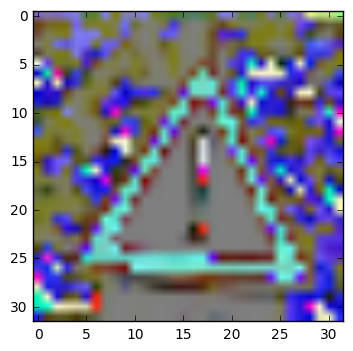

In [10]:
print('Mean: %0.4f | Std: %0.4f' % (np.mean(X_normalized[0,...]), np.std(X_normalized[0,...])))
plt.imshow(X_normalized[0,...])

In [11]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert math.isclose(np.min(X_normalized), -0.5, abs_tol=1e-5) and math.isclose(np.max(X_normalized), 0.5, abs_tol=1e-5), 'The range of the training data is: {} to {}.  It must be -0.5 to 0.5'.format(np.min(X_normalized), np.max(X_normalized))
print('Tests passed.')

Tests passed.


### One-Hot Encode the labels
Hint: You can use the [scikit-learn LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) function to one-hot encode the labels.

In [12]:
def one_hot(vector):
    if vector.ndim > 1: return vector
    
    n_classes = len(set(vector))
    return np.array([[1 if i == vector[j] else 0 for i in range(n_classes)] 
                     for j in range(len(vector))])

In [13]:
y_one_hot = one_hot(y_train)
print(y_one_hot.shape)

(39209, 43)


In [14]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
import collections

assert y_one_hot.shape == (39209, 43), 'y_one_hot is not the correct shape.  It\'s {}, it should be (39209, 43)'.format(y_one_hot.shape)
assert next((False for y in y_one_hot if collections.Counter(y) != {0: 42, 1: 1}), True), 'y_one_hot not one-hot encoded.'
print('Tests passed.')

Tests passed.


## Keras Sequential Model
```python
from keras.models import Sequential

# Create the Sequential model
model = Sequential()
```
The `keras.models.Sequential` class is a wrapper for the neural network model. Just like many of the class models in scikit-learn, it provides common functions like `fit()`, `evaluate()`, and `compile()`.  We'll cover these functions as we get to them.  Let's start looking at the layers of the model.

## Keras Layer
A Keras layer is just like a neural network layer.  It can be fully connected, max pool, activation, etc.  You can add a layer to the model using the model's `add()` function.  For example, a simple model would look like this:
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten

# Create the Sequential model
model = Sequential()

# 1st Layer - Add a flatten layer
model.add(Flatten(input_shape=(32, 32, 3)))

# 2nd Layer - Add a fully connected layer
model.add(Dense(100))

# 3rd Layer - Add a ReLU activation layer
model.add(Activation('relu'))

# 4th Layer - Add a fully connected layer
model.add(Dense(60))

# 5th Layer - Add a ReLU activation layer
model.add(Activation('relu'))
```
Keras will automatically infer the shape of all layers after the first layer.  This means you only have to set the input dimensions for the first layer.

The first layer from above, `model.add(Flatten(input_shape=(32, 32, 3)))`, sets the input dimension to (32, 32, 3) and output dimension to (3072=32\*32\*3).  The second layer takes in the output of the first layer and sets the output dimenions to (100).  This chain of passing output to the next layer continues until the last layer, which is the output of the model.

## Build a Multi-Layer Feedforward Network

Build a multi-layer feedforward neural network to classify the traffic sign images.

1. Set the first layer to a `Flatten` layer with the `input_shape` set to (32, 32, 3)
2. Set the second layer to `Dense` layer width to 128 output. 
3. Use a ReLU activation function after the second layer.
4. Set the output layer width to 43, since there are 43 classes in the dataset.
5. Use a softmax activation function after the output layer.

To get started, review the Keras documentation about [models](https://keras.io/models/sequential/) and [layers](https://keras.io/layers/core/).

The Keras example of a [Multi-Layer Perceptron](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py) network is similar to what you need to do here. Use that as a guide, but keep in mind that there are a number of differences.

In [15]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Activation

model = Sequential()

model.add(Flatten(input_shape=(32,32,3)))

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(43))
model.add(Activation('softmax'))

Using TensorFlow backend.


In [16]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
from keras.layers.core import Dense, Activation, Flatten
from keras.activations import relu, softmax

def check_layers(layers, true_layers):
    assert len(true_layers) != 0, 'No layers found'
    for layer_i in range(len(layers)):
        assert isinstance(true_layers[layer_i], layers[layer_i]), 'Layer {} is not a {} layer'.format(layer_i+1, layers[layer_i].__name__)
    assert len(true_layers) == len(layers), '{} layers found, should be {} layers'.format(len(true_layers), len(layers))

check_layers([Flatten, Dense, Activation, Dense, Activation], model.layers)

assert model.layers[0].input_shape == (None, 32, 32, 3), 'First layer input shape is wrong, it should be (32, 32, 3)'
assert model.layers[1].output_shape == (None, 128), 'Second layer output is wrong, it should be (128)'
assert model.layers[2].activation == relu, 'Third layer not a relu activation layer'
assert model.layers[3].output_shape == (None, 43), 'Fourth layer output is wrong, it should be (43)'
assert model.layers[4].activation == softmax, 'Fifth layer not a softmax activation layer'
print('Tests passed.')

Tests passed.


## Training a Sequential Model
You built a multi-layer neural network in Keras, now let's look at training a neural network.
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation

model = Sequential()
...

# Configures the learning process and metrics
model.compile('sgd', 'mean_squared_error', ['accuracy'])

# Train the model
# History is a record of training loss and metrics
history = model.fit(x_train_data, Y_train_data, batch_size=128, nb_epoch=2, validation_split=0.2)

# Calculate test score
test_score = model.evaluate(x_test_data, Y_test_data)
```
The code above configures, trains, and tests the model.  The line `model.compile('sgd', 'mean_squared_error', ['accuracy'])` configures the model's optimizer to `'sgd'`(stochastic gradient descent), the loss to `'mean_squared_error'`, and the metric to `'accuracy'`.  

You can find more optimizers [here](https://keras.io/optimizers/), loss functions [here](https://keras.io/objectives/#available-objectives), and more metrics [here](https://keras.io/metrics/#available-metrics).

To train the model, use the `fit()` function as shown in `model.fit(x_train_data, Y_train_data, batch_size=128, nb_epoch=2, validation_split=0.2)`.  The `validation_split` parameter will split a percentage of the training dataset to be used to validate the model.  The model can be further tested with the test dataset using the `evaluation()` function as shown in the last line.

## Train the Network

1. Compile the network using adam optimizer and categorical_crossentropy loss function.
2. Train the network for ten epochs and validate with 20% of the training data.

In [17]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=128, nb_epoch=10, validation_split=0.2)

Train on 31367 samples, validate on 7842 samples
Epoch 1/10
31367/31367 [==============================] - 28s - loss: 1.7597 - acc: 0.5454 - val_loss: 1.1436 - val_acc: 0.6685

In [18]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
from keras.optimizers import Adam

assert model.loss == 'categorical_crossentropy', 'Not using categorical_crossentropy loss function'
assert isinstance(model.optimizer, Adam), 'Not using adam optimizer'
assert len(history.history['acc']) == 10, 'You\'re using {} epochs when you need to use 10 epochs.'.format(len(history.history['acc']))

assert history.history['acc'][-1] > 0.92, 'The training accuracy was: %.3f. It shoud be greater than 0.92' % history.history['acc'][-1]
assert history.history['val_acc'][-1] > 0.85, 'The validation accuracy is: %.3f. It shoud be greater than 0.85' % history.history['val_acc'][-1]
print('Tests passed.')

Tests passed.


## Convolutions
1. Re-construct the previous network
2. Add a [convolutional layer](https://keras.io/layers/convolutional/#convolution2d) with 32 filters, a 3x3 kernel, and valid padding before the flatten layer.
3. Add a ReLU activation after the convolutional layer.

Hint 1: The Keras example of a [convolutional neural network](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py) for MNIST would be a good example to review.

In [19]:
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(32,32,3)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(43))
model.add(Activation('softmax'))

In [20]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D

check_layers([Convolution2D, Activation, Flatten, Dense, Activation, Dense, Activation], model.layers)

assert model.layers[0].input_shape == (None, 32, 32, 3), 'First layer input shape is wrong, it should be (32, 32, 3)'
assert model.layers[0].nb_filter == 32, 'Wrong number of filters, it should be 32'
assert model.layers[0].nb_col == model.layers[0].nb_row == 3, 'Kernel size is wrong, it should be a 3x3'
assert model.layers[0].border_mode == 'valid', 'Wrong padding, it should be valid'

model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=128, nb_epoch=2, validation_split=0.2)
assert(history.history['val_acc'][-1] > 0.91), "The validation accuracy is: %.3f.  It should be greater than 0.91" % history.history['val_acc'][-1]
print('Tests passed.')

Train on 31367 samples, validate on 7842 samples
Epoch 1/2
31367/31367 [==============================] - 6s - loss: 1.1156 - acc: 0.7130 - val_loss: 0.4317 - val_acc: 0.8847

## Pooling
1. Re-construct the network
2. Add a 2x2 [max pooling layer](https://keras.io/layers/pooling/#maxpooling2d) immediately following your convolutional layer.

In [21]:
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(32,32,3)))
model.add(MaxPooling2D((2,2), (2,2), 'valid'))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(43))
model.add(Activation('softmax'))

In [22]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

check_layers([Convolution2D, MaxPooling2D, Activation, Flatten, Dense, Activation, Dense, Activation], model.layers)
assert model.layers[1].pool_size == (2, 2), 'Second layer must be a max pool layer with pool size of 2x2'

model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=128, nb_epoch=2, validation_split=0.2)
assert(history.history['val_acc'][-1] > 0.91), "The validation accuracy is: %.3f.  It should be greater than 0.91" % history.history['val_acc'][-1]
print('Tests passed.')

Train on 31367 samples, validate on 7842 samples
Epoch 1/2
31367/31367 [==============================] - 3s - loss: 1.3880 - acc: 0.6441 - val_loss: 0.5856 - val_acc: 0.8483

## Dropout
1. Re-construct the network
2. Add a [dropout](https://keras.io/layers/core/#dropout) layer after the pooling layer. Set the dropout rate to 50%.

In [23]:
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(32,32,3)))
model.add(MaxPooling2D((2,2), (2,2), 'valid'))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(43))
model.add(Activation('softmax'))

In [25]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

check_layers([Convolution2D, MaxPooling2D, Dropout, Activation, Flatten, Dense, Activation, Dense, Activation], model.layers)
assert model.layers[2].p == 0.5, 'Third layer should be a Dropout of 50%'

model.compile('adam', 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_normalized, y_one_hot, batch_size=128, nb_epoch=2, validation_split=0.2)
assert(history.history['val_acc'][-1] > 0.91), "The validation accuracy is: %.3f.  It should be greater than 0.91" % history.history['val_acc'][-1]
print('Tests passed.')

Train on 31367 samples, validate on 7842 samples
Epoch 1/2
31367/31367 [==============================] - 3s - loss: 0.3282 - acc: 0.9123 - val_loss: 0.2175 - val_acc: 0.9526

## Optimization
Congratulations! You've built a neural network with convolutions, pooling, dropout, and fully-connected layers, all in just a few lines of code.

Have fun with the model and see how well you can do! Add more layers, or regularization, or different padding, or batches, or more training epochs.

What is the best validation accuracy you can achieve?

In [15]:
from keras.models import Sequential

from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import PReLU

model = Sequential()

model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(32,32,1)))
model.add(MaxPooling2D((2,2), (2,2), 'same'))
model.add(PReLU())

model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(MaxPooling2D((2,2), (2,2), 'same'))
model.add(PReLU())

model.add(Convolution2D(256, 3, 3, border_mode='same'))
model.add(MaxPooling2D((2,2), (2,2), 'same'))
model.add(PReLU())

model.add(Flatten())

model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(PReLU())

model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(PReLU())

model.add(Dense(256))
model.add(PReLU())

model.add(Dense(43))
model.add(Activation('softmax'))

Using TensorFlow backend.


In [ ]:
optimizer = keras.optimizers.Adam(decay=1e-5)
model.compile(optimizer, 'categorical_crossentropy', ['accuracy'])
history = model.fit(expanded_data, expanded_labels, batch_size=128, nb_epoch=20, 
                    validation_split=0.2, shuffle=True)

Train on 31367 samples, validate on 7842 samples
Epoch 1/2
31367/31367 [==============================] - 42s - loss: 3.4999 - acc: 0.0559 - val_loss: 3.4982 - val_acc: 0.0552

**Best Validation Accuracy:** 0.9920

## Testing
Once you've picked out your best model, it's time to test it.

Load up the test data and use the [`evaluate()` method](https://keras.io/models/model/#evaluate) to see how well it does.

Hint 1: The `evaluate()` method should return an array of numbers. Use the [`metrics_names`](https://keras.io/models/model/) property to get the labels.

In [ ]:
with open('test.p', 'rb') as f:
    data = pickle.load(f)

X_test, y_test = data['features'], data['labels']
X_test, y_test = shuffle(X_test, y_test)
X_test, y_test = pre_process(X_test), one_hot(y_test)

print(model.evaluate(X_test, y_test, batch_size=128))

**Test Accuracy:** 0.9637

## Summary
Keras is a great tool to use if you want to quickly build a neural network and evaluate performance.